In [1]:
import optuna
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import os, glob
import pandas as pd
from optuna.visualization.matplotlib import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_contour, plot_param_importances

from scipy.interpolate import griddata


In [ ]:
# You need to run TPE.py from src then you can visualize it 
# ---- config ----
folder = "../random/TPE/" # replace with TPE path if different
models = ["unet", "swin","restormer"] # edit if needed
save_file=False
pattern = os.path.join(folder, f"tpe_study_summary_*.csv")

pattern2 = os.path.join(folder, f"best_values.csv")
# ---- helper ----
def load_trials_csv(path):
    """Extract model, problem, learning_rate, and value from the CSV."""
    base = os.path.basename(path)
    parts = base.replace(".csv", "").split("_")
    # Example: ['tpe', 'study', 'summary', 'Lr', 'Bs', 'unet', 'firstbreak']
    model, problem = parts[-2], parts[-1]

    df = pd.read_csv(path, comment='#')
    df2=df.copy()
    #df = df.dropna(how="all")   # remove any fully-empty rows

    if "state" in df.columns:
        df = df[df["state"] != "FAIL"].copy()
        #df = df[df["state"] == "COMPLETE"].copy() # you can also only use the completed tested and not the pruned
           
    if "params_learning_rate" not in df.columns or "value" not in df.columns:
        return pd.DataFrame()

    df["learning_rate"] = pd.to_numeric(df["params_learning_rate"], errors="coerce")

    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df["model"] = model
    df["problem"] = problem
    if "params_batch_size" in df.columns:
        df["batch_size"] = pd.to_numeric(df["params_batch_size"], errors="coerce")
    else:
        df["batch_size"] = 8 # here we just add batch size 8 to the tests that we ran with fixed batch size 8 (replace if needed)

    return df[["model","state", "problem", "learning_rate","batch_size", "value"]].dropna()

# ---- read all ----
frames = []
for f in glob.glob(pattern):
    for model in models:
        if f"_{model}_" in f:
            frames.append(load_trials_csv(f))
df_all = pd.concat(frames, ignore_index=True)
print("Loaded models:", df_all["model"].unique())
print("Problems found:", df_all["problem"].unique())

df_best =pd.read_csv(pattern2)



Loaded models: ['restormer' 'swin' 'unet']
Problems found: ['denoise' 'firstbreak']


Plotting for problem: denoise


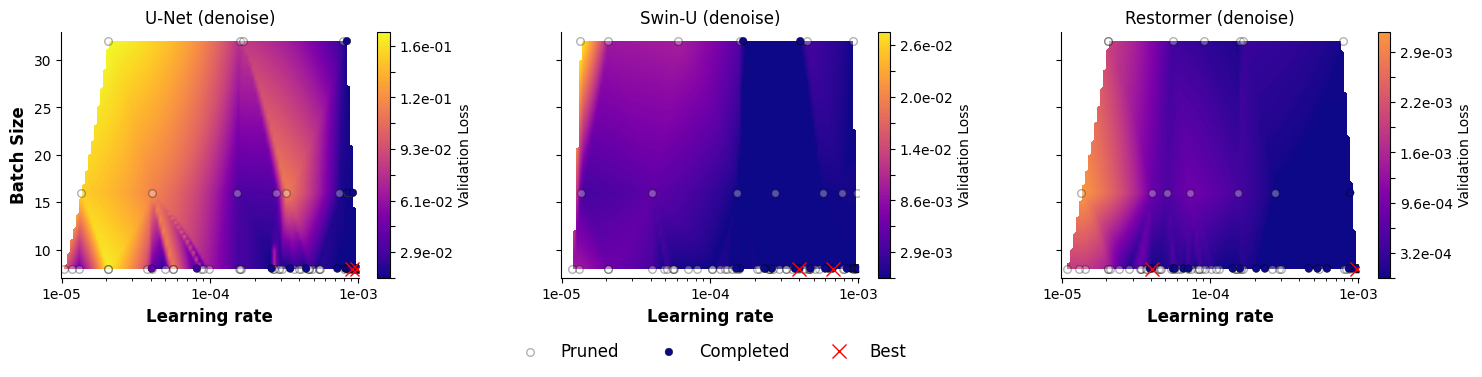

Plotting for problem: firstbreak


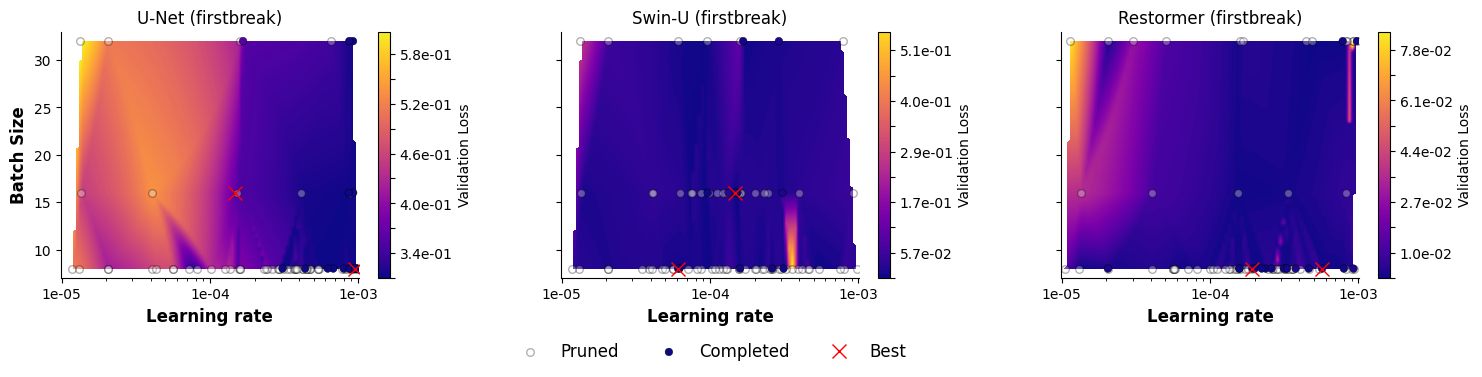

In [9]:

M={'unet':'U-Net', 'swin':'Swin-U','restormer':'Restormer'}
save_file= True

for problem, df_prob in df_all.groupby("problem"):

    print(f"Plotting for problem: {problem}")


    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4), squeeze=False, sharex=True, sharey=True)

    for ax, m in zip(axes.ravel(), models):
        
        sub = df_all[df_all["model"] == m]
        sub = sub[sub["problem"] == problem]
        best=df_best[df_best["model"] == m]
        best= best[best["problem"] == problem]
    
        # --- prepare data ---
        x = sub["learning_rate"].values
        y = sub["batch_size"].values
        z = sub["value"].values

        # --- create grid for contour ---
        xi = np.logspace(-5, -3, 100)          # LR grid
        yi = np.linspace(8, 32,100 )           # Batch size grid
        Xi, Yi = np.meshgrid(xi, yi)
        vmin, vmax = z.min(),z.max()

        # --- interpolate objective values onto grid ---
        Zi = griddata((x, y), z, (Xi, Yi), method='linear')
        Zi = np.clip(Zi, z.min(), z.max()) #cubic
        # --- contourf plot ---
        cntrf = ax.contourf(
            Xi, Yi, Zi,
            levels=200,
            cmap="plasma",
            vmin=vmin,
            vmax=vmax)
        
        sub_c = sub[sub["state"] == "COMPLETE"]
        sub_p = sub[sub["state"] == "PRUNED"]

        if not sub_p.empty:
            ax.scatter(
                sub_p["learning_rate"], sub_p["batch_size"],
                c="w", edgecolor="k",s=30, alpha=0.3, label="Pruned"
            )
        if not sub_c.empty:
            ax.scatter(
                sub_c["learning_rate"], sub_c["batch_size"],
                c=sub_c["value"], cmap="plasma", #norm=norm,
                s=30, edgecolor="k", linewidth=0.3, label="Completed",vmin=vmin, 
            vmax=vmax
            )

        # --- formatting ---
        ax.grid(False)
        ax.set_facecolor("white")
       # Show only x and y axis lines
        ax.spines["bottom"].set_visible(True)
        ax.spines["left"].set_visible(True)
        ax.spines["bottom"].set_color("black")
        ax.spines["left"].set_color("black")

        # Hide top and right frame lines
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

        # Make tick labels black
        ax.tick_params(axis="both", colors="black", labelsize=10)
        ax.set_xscale("log")
        ax.set_xlim(0.99e-5, 1.01e-3)
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.0e'))
        ax.set_xlabel("Learning rate",fontsize=12, fontweight='bold')
            
        ax.set_title(f"{M[m]} ({problem})")
        ax.set_ylim(7, 33)

        # --- colorbar ---
        formatter = ticker .FormatStrFormatter('%.1e')
        cbar = plt.colorbar(cntrf, ax=ax,format=formatter)
        cbar.set_label("Validation Loss")
     
    
        ax.plot(best['learning_rate'],best['batch_size'],'xr', markersize=10, label='Best')
        if m =='unet':
            ax.set_ylabel("Batch Size", fontsize=12, fontweight='bold')
        if m =='swin':
            h,l = ax.get_legend_handles_labels()

            L=ax.legend(h, l, loc='upper center', bbox_to_anchor=(0.5, -0.2),
                            fontsize=12,
                            labelcolor='k',facecolor='none',edgecolor='none',ncol=6)  

        for label in cbar.ax.yaxis.get_ticklabels()[::2]:
            label.set_visible(False)


    fig.tight_layout()

    if save_file:
        fig.savefig(os.path.join(folder, f"contour_lr_bs_{problem}.png"), dpi=200)

    plt.show()




    
        


